In [487]:
using DrWatson

@quickactivate

In [655]:
# so we can keep adding packages to the venv
"""using Pkg
Pkg.add("ProfileSVG")"""

   Resolving package versions...
   Installed libvorbis_jll ────── v1.3.8+0
   Installed GeometryBasics ───── v0.5.10
   Installed Wayland_jll ──────── v1.23.1+2
   Installed OrdinaryDiffEqCore ─ v1.26.2
   Installed ProfileSVG ───────── v0.2.2
   Installed Moshi ────────────── v0.3.7
   Installed ColorSchemes ─────── v3.30.0
    Updating `~/Desktop/Uni/PhD/open_q_systems/open_system_tn/Project.toml`
  [132c30aa] + ProfileSVG v0.2.2
    Updating `~/Desktop/Uni/PhD/open_q_systems/open_system_tn/Manifest.toml`
  [35d6a980] ↑ ColorSchemes v3.29.0 ⇒ v3.30.0
⌅ [5ae59095] ↓ Colors v0.13.1 ⇒ v0.12.11
  [68eda718] - GeoFormatTypes v0.4.4
  [cf35fbd7] - GeoInterface v1.4.1
  [5c1252a2] ↑ GeometryBasics v0.5.9 ⇒ v0.5.10
  [2e0e35c7] ↑ Moshi v0.3.6 ⇒ v0.3.7
  [bbf590c4] ↑ OrdinaryDiffEqCore v1.26.1 ⇒ v1.26.2
  [132c30aa] + ProfileSVG v0.2.2
  [a2964d1f] ↑ Wayland_jll v1.23.1+1 ⇒ v1.23.1+2
  [f27f6e37] ↑ libvorbis_jll v1.3.7+2 ⇒ v1.3.8+0
        Info Packages marked with ⌅ have new versions availa

In [658]:
using CairoMakie
using SparseArrays
using LinearAlgebra
using Statistics
using Profile, ProfileSVG



In [490]:
using QuantumToolbox
using ITensors, ITensorMPS


"""# this is for compiling an itensor image so when we start it does not take ages to 
# comile the pakages. This only needs to be run onces per machine or when you update the packages
# to create the sys_itensor.so image

using PackageCompiler

ITensors.compile()

# To load the image in a jupyter notebook:
# using IJulia
# installkernel("julia_ITensors","--sysimage=~/.julia/sysimages/sys_itensors.so")
# To load the image in vscode just add this to the julia.additionalArgs setting in Settings.json
# "--sysimage ~/.julia/sysimages/sys_itensors.so"
"""

"# this is for compiling an itensor image so when we start it does not take ages to \n# comile the pakages. This only needs to be run onces per machine or when you update the packages\n# to create the sys_itensor.so image\n\nusing PackageCompiler\n\nITensors.compile()\n\n# To load the image in a jupyter notebook:\n# using IJulia\n# installkernel(\"julia_ITensors\",\"--sysimage=~/.julia/sysimages/sys_itensors.so\")\n# To load the image in vscode just add this to the julia.additionalArgs setting in Settings.json\n# \"--sysimage ~/.julia/sysimages/sys_itensors.so\"\n"

# Exact Diagonalization

In [491]:
N = 3 # local hilbert space dimension
L = 6 # size of the chain
ω = 0 # frequency of the harmonic oscillator
J = 1.0 # hopping
γ = 0.1 # damping rate
maxt = 30 # maximum time

30

In [492]:
# annihilation operator list
aj_list = []
a = destroy(N) # annihilation operator

# make sure we are type stable
sparseId = SparseMatrixCSC(Diagonal{ComplexF64}(ones(N)))
Id = QuantumObject(sparseId)
# Create the annihilation opeartors at each lattice site
for i in range(1,L)
    local_list = fill(Id,L)
    local_list[i] = a
    # annihilation acting on j
    push!(aj_list,tensor(local_list ...));
end


In [493]:
# create the hamiltonian
H = ω*aj_list[1]' * aj_list[1] 

for i in range(2,L)
    H+= ω*aj_list[i]' * aj_list[i]  + J* (aj_list[i-1]' * aj_list[i]+ aj_list[i]' * aj_list[i-1])
end


In [494]:
s_list = fill(fock(N,0),L)
s_list[1] = fock(N,1)
# ψ0 = tensor(fock(L, 2),fock(L,0),fock(L,0)) # initial state

ψ0 = tensor(s_list...); # initial state

In [495]:

# c_ops = [sqrt(γ) * aj_list[end]]
c_ops = sqrt(γ) .* aj_list
e_ops = [aj_list[1]' * aj_list[1], aj_list[end]' * aj_list[end]]
tlist = range(0, maxt, 200) # time list


result = mesolve(H, ψ0, tlist, c_ops, e_ops = e_ops)

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)


Solution of time evolution
(return code: Success)
--------------------------
num_states = 1
num_expect = 2
ODE alg.: OrdinaryDiffEqTsit5.Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false))
abstol = 1.0e-8
reltol = 1.0e-6


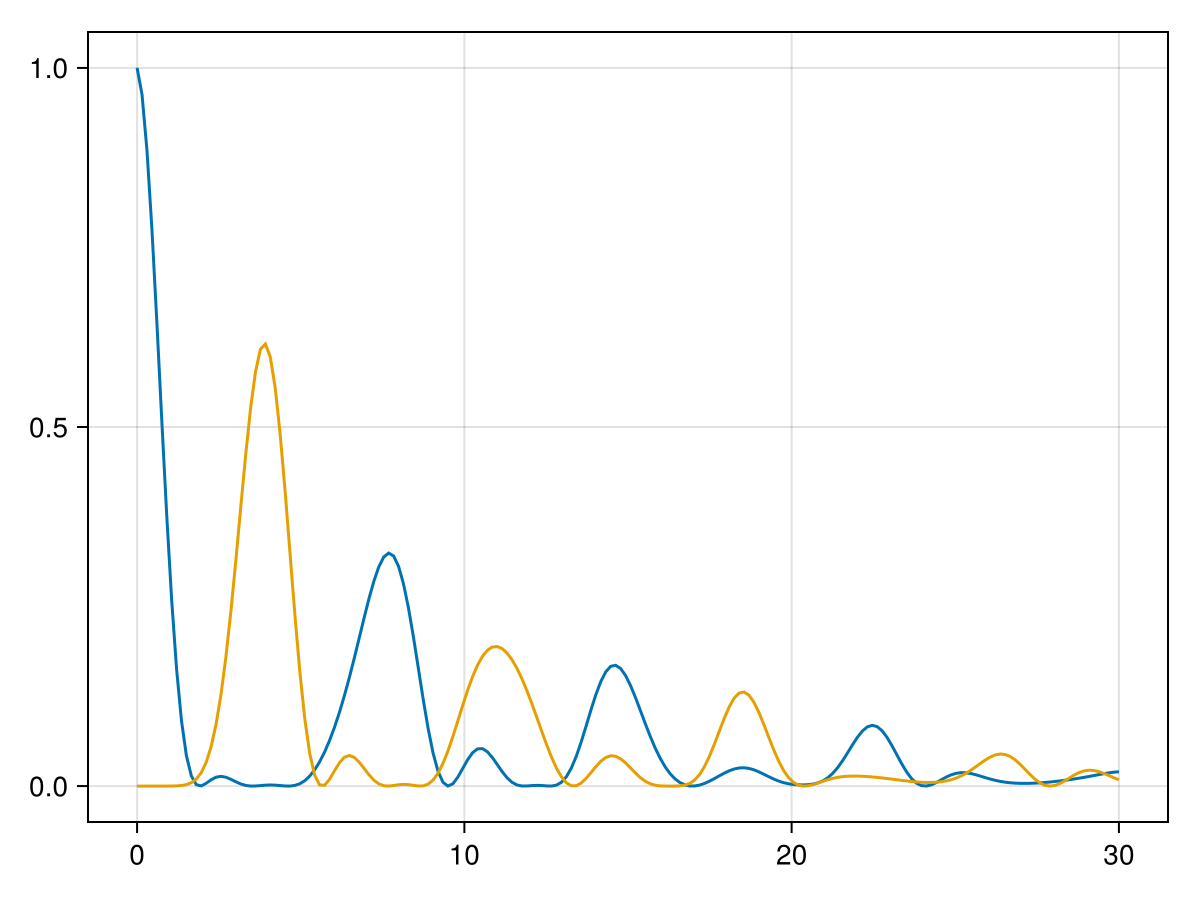

In [496]:
f = Figure()
ax = Axis(f[1, 1])

lines!(tlist, real(result.expect[1,1:end]))
lines!(tlist, real(result.expect[2,1:end]))

f

# Closed MPS 

In [497]:
function entangement_S(ψ, b)
    # b: index where we do the bipartition
    psi = orthogonalize(ψ, b)
    # do the SVM
    U,S,V = svd(psi[b], (linkinds(psi, b-1)..., siteinds(psi, b)...))
    SvN = 0.0
    # Geth the schmidt coefficients
    for n=1:dim(S, 1)
        p = S[n,n]^2
        SvN -= p * log(p)
    end
    return SvN
end

function main_TN(L, J, Δτ, ttotal, Nh, cutoff=1E-8  )
    # bettwe to put it in a function to avoid the global julia scope
    """ L = chain size
    J = Hopping
    Δτ = timestep
    ttotal = final time
    cutoff = truncation cutoff
    Nh = local hilbert space dimension"""

    occupations = []
    times = []
    entropies = []
    #  build site indices
    s = siteinds("Boson", L; dim=Nh, conserve_qns=true)
    # build the time evol gates for TEBD
    gates = ITensor[]
    for j in 1:(L-1)
        s1 = s[j]
        s2 = s[j+1] 
        hj = op("adag",s1)*op("a",s2) + op("adag",s2)*op("a",s1)
        # troterized gate
        Gj = exp(-im * Δτ/2 * hj)
        push!(gates, Gj)

    end
    # The reverse gates for second order accuracy
    append!(gates, reverse(gates))
    # put a particle in the first site
    state_list = ["0" for n in 1:L]
    state_list[1] = "2"
    psi = MPS(s, state_list)

    for t in 0.0:Δτ:ttotal

        # keep track of the occupations at each time step
        occ = ITensorMPS.expect(psi,"N")
        # entanglement entropy between two equal sized parts of the chain
        Svn = entangement_S(psi, Integer(L/2))
        push!(occupations, occ)
        push!(times, t)
        push!(entropies, Svn)

        t≈ttotal && break

        psi = apply(gates, psi; cutoff)
        normalize!(psi)
    end
    return occupations, times, entropies
end


main_TN (generic function with 3 methods)

In [498]:
Occupations, times, Svns = main_TN(L, J,tlist[2]-tlist[1], maxt,N);
Occupations = reduce(hcat, Occupations)


6×200 Matrix{Float64}:
 2.0  1.95514      1.82556     1.62546     …  0.707346   0.740858   0.761734
 0.0  0.0446028    0.170476    0.355352       0.0231656  0.0117834  0.0025923
 0.0  0.000252907  0.00391111  0.0187026      0.353149   0.277      0.194692
 0.0  1.4424e-6    5.03285e-5  0.00048081     0.0553455  0.161022   0.316408
 0.0  0.0          3.92439e-7  7.86632e-6     0.253954   0.322169   0.352443
 0.0  0.0          0.0         6.75258e-8  …  0.607039   0.487168   0.372131

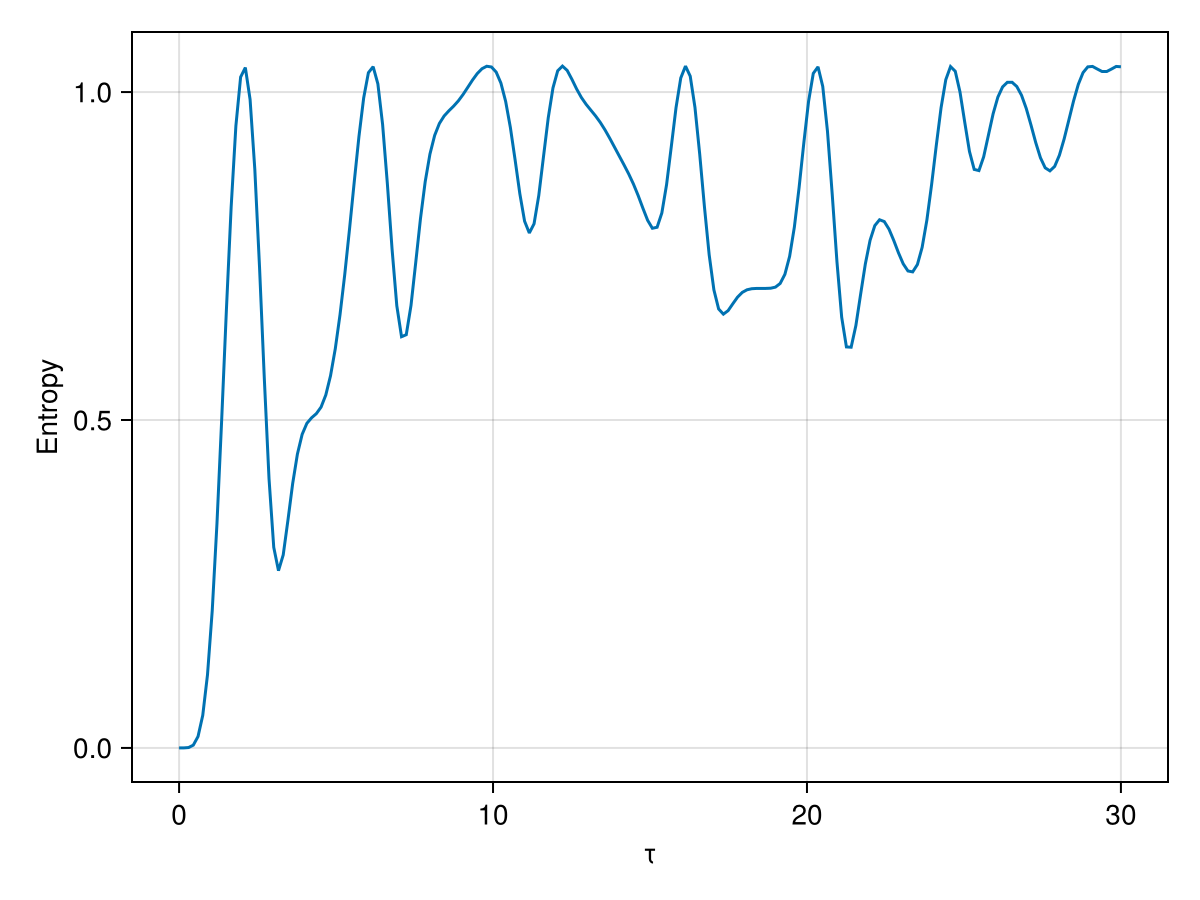

In [499]:
f = Figure()
ax = Axis(f[1, 1], xlabel="τ", ylabel="Entropy")

lines!(times, Svns)
f

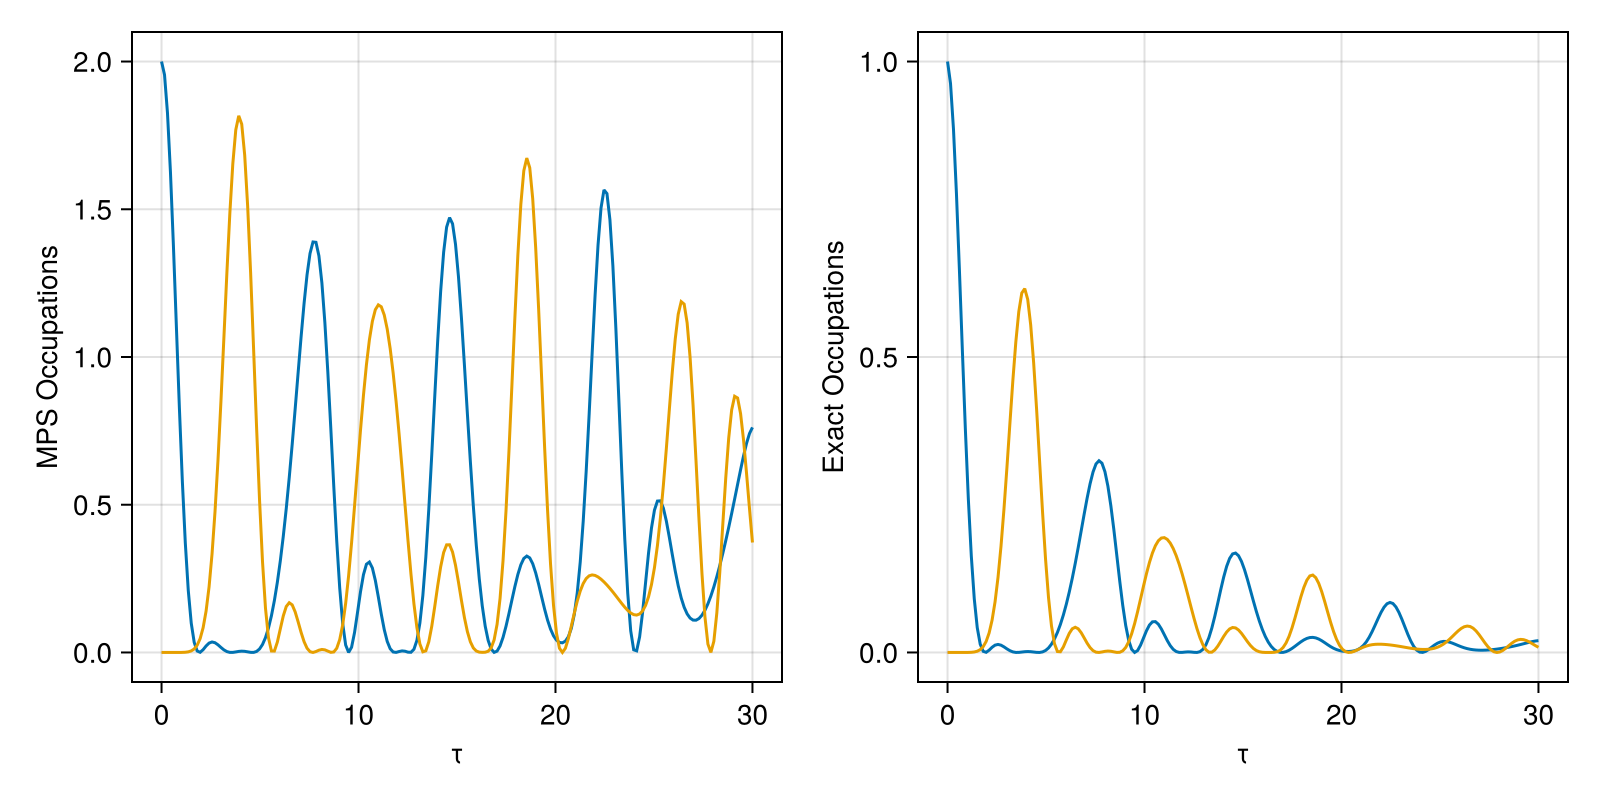

In [500]:
f = Figure(size = (800, 400))
ax1 = Axis(f[1, 1],xlabel="τ", ylabel="MPS Occupations")
ax2 = Axis(f[1, 2],xlabel="τ", ylabel="Exact Occupations")

lines!(ax1, times, Occupations[1,1:end])
lines!(ax1, times, Occupations[end,1:end])

lines!(ax2, tlist, real(result.expect[1,1:end]))
lines!(ax2, tlist, real(result.expect[2,1:end]))
f


# Open System MPS

Using trajectories as shown in https://www.scipost.org/10.21468/SciPostPhys.15.4.152

In [654]:
function ask_where(intervals)
    # decide where to project the staet when there is a jump, each element in intervals is associated to
    # a jump operator
    r2 = rand()
    dummy = 0
    j = 1
    found_site = -1
    while dummy == 0
        if r2<sum(intervals[1:j])
            dummy = 1
            found_site = j
        else 
            j = j+1
        end
    end
    return found_site
end

function build_TEBD(L, J, Δτ, Nh, γ)
    gammas = zeros(L) # list for where the dissipations act
    gammas[1:end] .= γ 
    #  build site indices
    s = siteinds("Boson", L; dim=Nh, conserve_qns=false)
    # build the time evol gates for TEBD
    gates = ITensor[]
    for j in 1:(L-1)
        s1 = s[j]
        s2 = s[j+1] 
         # for the last site

        hj = op("adag",s1)*op("a",s2) + op("adag",s2)*op("a",s1) - 0.5*im * gammas[j]*op("n",s1)*op("Id",s2)
        # troterized gate
        Gj = exp(-im * Δτ/2 * hj)
        push!(gates, Gj)
    end

    hj = - 0.5*im*gammas[end]*op("Id",s[end-1])*op("n",s[end])
    Gj = exp(-im * Δτ/2 * hj)
    push!(gates, Gj)
    # The reverse gates for second order accuracy
    append!(gates, reverse(gates))

    return s, gates

end

function compute_trajectory(s, gates, L, J, Δτ, ttotal, Nh, γ, cutoff=1E-8)
    # bettwe to put it in a function to avoid the global julia scope
    """ 
    s = indices for truncation
    Gj = TEBD circuit for one step
    L = chain size
    J = Hopping
    Δτ = timestep
    ttotal = final time
    cutoff = truncation cutoff
    Nh = local hilbert space dimension
    gamma = dissipation
    """

    
    gammas = zeros(L) # list for where the dissipations act
    gammas[1:end] .= γ # for now only dissipation at the end of the chain
    norms = [] # track the norm of the state because we have non-hermitian evolution
    occupations = []
    times = []
    entropies = []
    
    # put a particle in the first site
    state_list = ["0" for n in 1:L]
    state_list[1] = "1"
    psi = MPS(s, state_list)

    for t in 0.0:Δτ:ttotal
        # keep track of the occupations at each time step
        occ = ITensorMPS.expect(psi,"N")        
        # entanglement entropy between two equal sized parts of the chain
        Svn = entangement_S(psi, Integer(L/2))
        push!(occupations, occ)
        push!(times, t)
        push!(entropies, Svn)
        push!(norms, inner(psi',psi))

        t≈ttotal && break

        # metropolis step
        psi_cand = apply(gates, psi; cutoff) # candidate for new state}
        norm = inner(psi_cand',psi_cand)
        proba_act = real(1 - norm)
        r1 = rand()
        if r1 > proba_act
            # here no jump so we accept the state
            psi = psi_cand/norm

        else
            # jump, so choose which state we project to
            δp_list = [gammas[i]*ITensorMPS.expect(psi,"N",sites=i) for i in 1:L]  
            normalize!(δp_list)
            jump_site = ask_where(δp_list)
            jump_op = sqrt(gammas[jump_site])*op("a",s[jump_site]);
            #psi = sqrt(Δτ/δp_list[jump_site])*apply(jump_op , psi)
            psi = apply(jump_op , psi)
            normalize!(psi)
        end
        
    end
    return occupations, times, entropies, norms
end



Gtk4.GtkWindowLeaf(accessible-role=GTK_ACCESSIBLE_ROLE_WINDOW, name="", parent, root, width-request=-1, height-request=-1, visible=true, sensitive=true, can-focus=true, has-focus=false, can-target=true, focus-on-click=true, focusable=false, has-default=false, receives-default=false, cursor, has-tooltip=false, tooltip-markup=nothing, tooltip-text=nothing, opacity=1.000000, overflow=GTK_OVERFLOW_HIDDEN, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, hexpand=false, vexpand=false, hexpand-set=false, vexpand-set=false, scale-factor=2, css-name="window", css-classes, layout-manager, limit-events=false, title="Profile", resizable=true, modal=false, default-width=800, default-height=600, destroy-with-parent=false, hide-on-close=false, icon-name=nothing, display, decorated=true, deletable=true, transient-for, application, default-widget, focus-widget, child, titlebar, handle-menubar-accel=true, is-active=false, suspended=false, startup

In [672]:
s_indices, gates =build_TEBD(L, J,tlist[2]-tlist[1], N, γ)

Profile.clear()

@profile compute_trajectory(s_indices, gates, L, J,tlist[2]-tlist[1], 10, N, γ);

ProfileSVG.save("prof.svg")

┌ Warning: The depth of this graph is 73, exceeding the `maxdepth` (=50).
│ The deeper frames will be truncated.
└ @ ProfileSVG /Users/santiago/.julia/packages/ProfileSVG/mZ6ea/src/ProfileSVG.jl:294


In [638]:
# Do an ensemble average over all trajectories to get the actual occupatinos
N_trajectories = 50
occupation_ensemble = []

s_indices, gates =build_TEBD(L, J,tlist[2]-tlist[1], N, γ)

for traj in 1:N_trajectories
    if(traj%10==0)
        println(traj)
    end

    occupations, times, Svns, norms = compute_trajectory(s_indices, gates, L, J,tlist[2]-tlist[1], maxt, N, γ);
    occupations = reduce(hcat, occupations);
    push!(occupation_ensemble, occupations)
    
end


10
20
30
40
50


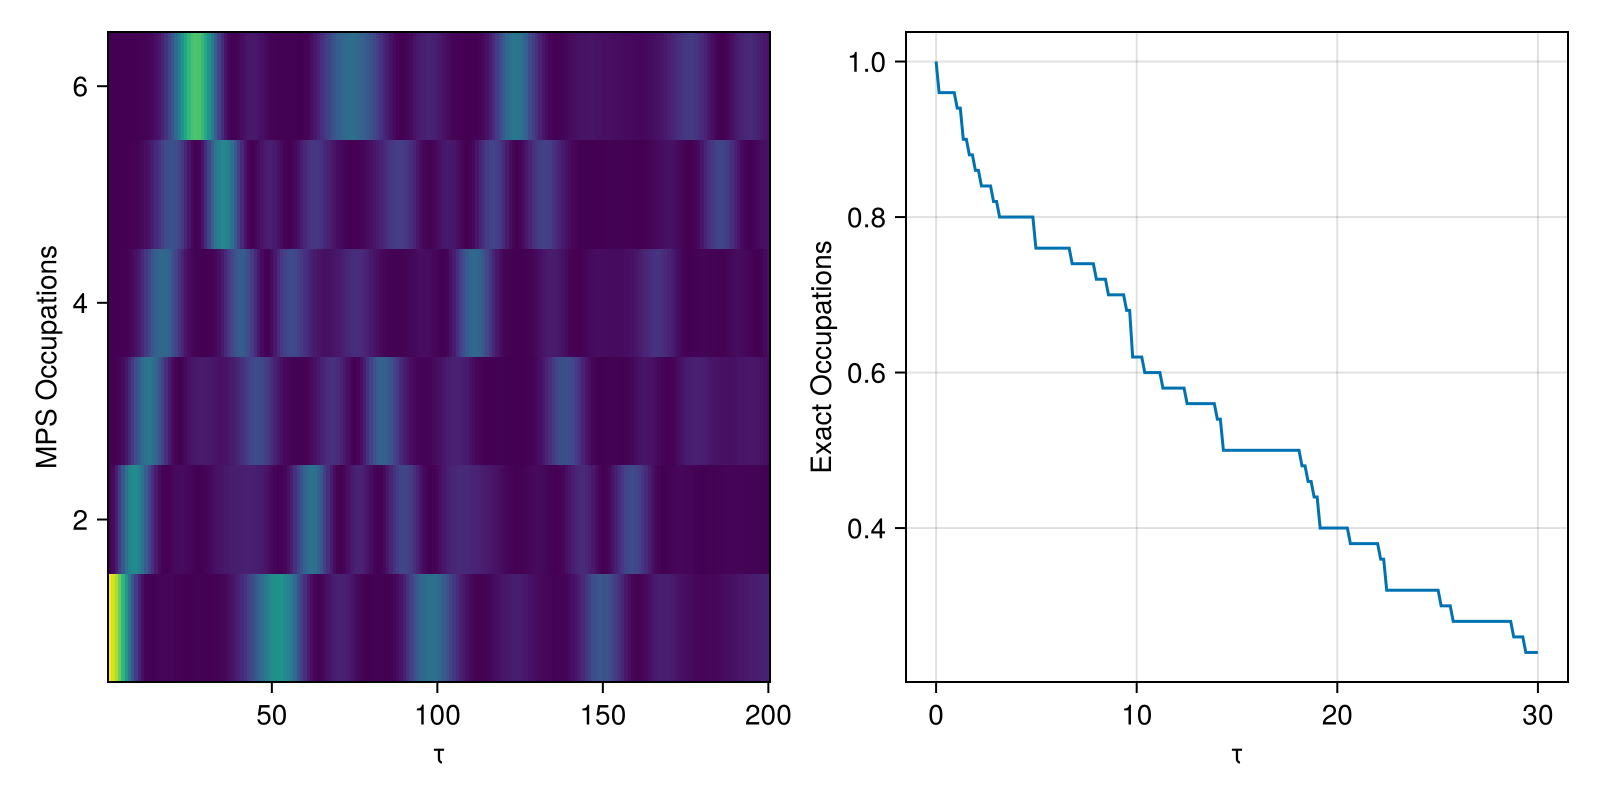

In [639]:
mean_traj = mean(occupation_ensemble)
tot_oc = sum(mean_traj, dims=1)[1:end]

f = Figure(size = (800, 400))
ax1 = Axis(f[1, 1],xlabel="τ", ylabel="MPS Occupations")
ax2 = Axis(f[1, 2],xlabel="τ", ylabel="Exact Occupations")

heatmap!(ax1, transpose(mean_traj))
lines!(ax2, times, tot_oc)

f


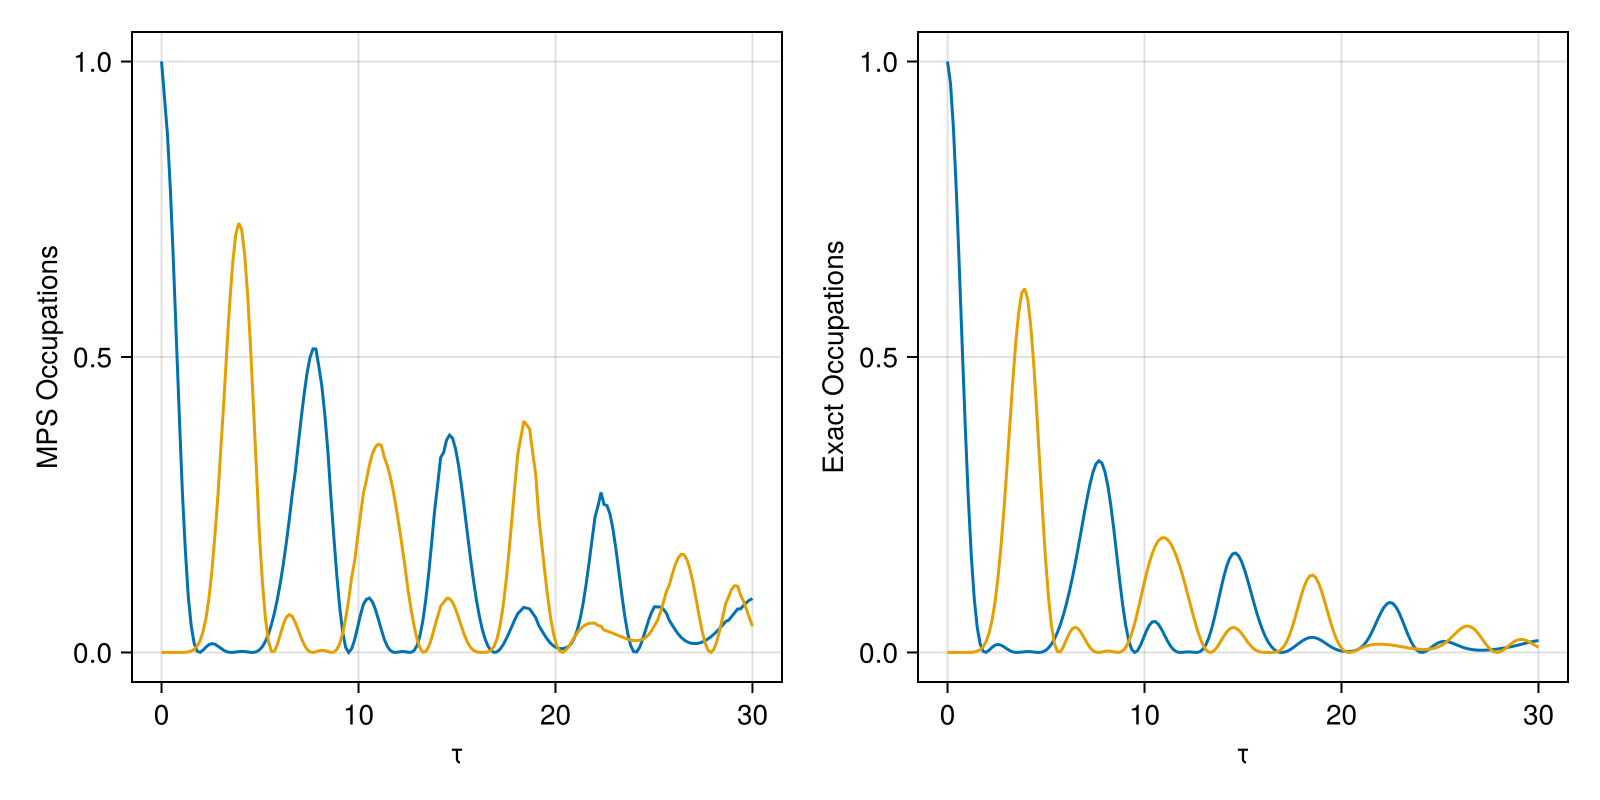

In [641]:
f = Figure(size = (800, 400))
ax1 = Axis(f[1, 1],xlabel="τ", ylabel="MPS Occupations")
ax2 = Axis(f[1, 2],xlabel="τ", ylabel="Exact Occupations")

lines!(ax1, times, mean_traj[1,1:end])
lines!(ax1, times, mean_traj[end,1:end])

lines!(ax2, tlist, real(result.expect[1,1:end]))
lines!(ax2, tlist, real(result.expect[2,1:end]))

f